- Use clustering as a feature engineering tool
- Implement random forest and gradient boosting classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import *

In [2]:
data=pd.read_csv("attrition.csv")

In [3]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
data['Attrition'] = np.where(data.Attrition=='Yes', 1, 0)

In [5]:
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')


In [6]:
# drop columns with only one value
data = data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

In [7]:
data.Attrition.value_counts(normalize=True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

In [8]:
#separating X and Y
Y=data["Attrition"]
X=data.drop("Attrition",axis=1)

In [9]:
#making dummes,train test split
X=pd.get_dummies(X, drop_first=True)

In [10]:
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

## K-Means 

We will use predicted clusters as a feature for the classification problem

In [11]:
# we need to scale the data for clustering
scaler = StandardScaler()
scaler.fit(X0)
X0_scaled = pd.DataFrame(scaler.transform(X0), columns=X0.columns)
X1_scaled = pd.DataFrame(scaler.transform(X1), columns=X1.columns)

In [12]:
sse = {}
for k in range(2,10):
    clusters = KMeans(n_clusters=k, random_state=42)
    X0['clusters']=clusters.fit_predict(X0_scaled)
    sse[k] = clusters.inertia_ 

<ipython-input-12-8bbd88950723>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X0['clusters']=clusters.fit_predict(X0_scaled)
<ipython-input-12-8bbd88950723>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X0['clusters']=clusters.fit_predict(X0_scaled)
<ipython-input-12-8bbd88950723>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

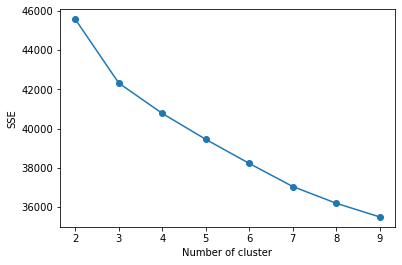

In [13]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker="o") #sse is dictionary 
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Based on the graph we can see that the optimal number of clusters is 3

In [14]:
#Let's use the optimal value of k and create a feature
km_model = KMeans(n_clusters=3, random_state=42).fit(X0_scaled)

In [15]:
X0['clusters'] = km_model.predict(X0_scaled)
X1['clusters'] = km_model.predict(X1_scaled)

<ipython-input-15-0921b7ca09e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X0['clusters'] = km_model.predict(X0_scaled)
<ipython-input-15-0921b7ca09e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1['clusters'] = km_model.predict(X1_scaled)


## Random Forest

In [16]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=4, n_estimators=10,
                           min_samples_leaf=120)
rf.fit(X0, Y0)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=120, n_estimators=10, random_state=42)

In [17]:
#for classification you should predict probabilities
Y0_pred=rf.predict_proba(X0)[:,1]
Y1_pred=rf.predict_proba(X1)[:,1]

In [18]:
#much higher ROC AUC score and almost no overfitting
print("ROC_AUC Train for Manually Tuned DT:", roc_auc_score(Y0, Y0_pred))
print("ROC_AUC Test for Manually Tuned DT:", roc_auc_score(Y1, Y1_pred))

ROC_AUC Train for Manually Tuned DT: 0.776085583314499
ROC_AUC Test for Manually Tuned DT: 0.6776692708333333


In [53]:
gridsearch_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                          param_grid={'max_depth':range(1,5), 'n_estimators': range(10,100,10),
                                      'class_weight':['balanced',None], 'min_samples_leaf': range(80,150,10)},
                          cv=5,scoring="roc_auc",n_jobs=-1).fit(X0,Y0)

best_rf = gridsearch_rf.best_params_
print(best_rf)

{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 80, 'n_estimators': 80}


In [19]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=4, n_estimators=80,
                           min_samples_leaf=80)
rf.fit(X0, Y0)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=80, n_estimators=80, random_state=42)

In [20]:
#for classification you should predict probabilities
Y0_pred=rf.predict_proba(X0)[:,1]
Y1_pred=rf.predict_proba(X1)[:,1]

In [21]:
#much higher ROC AUC score and almost no overfitting
print("ROC_AUC Train for Manually Tuned DT:", roc_auc_score(Y0, Y0_pred))
print("ROC_AUC Test for Manually Tuned DT:", roc_auc_score(Y1, Y1_pred))

ROC_AUC Train for Manually Tuned DT: 0.8232468111986184
ROC_AUC Test for Manually Tuned DT: 0.7026041666666667


In [23]:
# feature importance
pd.DataFrame(rf.feature_importances_, X0.columns.tolist(),columns=['imp']).sort_values(by='imp',ascending=False)

,imp
MonthlyIncome,0.143328
OverTime_Yes,0.114966
Age,0.096081
StockOptionLevel,0.081534
TotalWorkingYears,0.080323
YearsInCurrentRole,0.079469
YearsWithCurrManager,0.066390
JobLevel,0.053541
MaritalStatus_Single,0.050071
YearsAtCompany,0.047432


## Gradient Boosting

In [57]:
gbm=GradientBoostingClassifier(random_state=42, max_depth=4, learning_rate=0.01, n_estimators=200)
gbm.fit(X0, Y0)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=200,
                           random_state=42)

In [58]:
#for classification you should predict probabilities
Y0_pred=gbm.predict_proba(X0)[:,1]
Y1_pred=gbm.predict_proba(X1)[:,1]

In [59]:
#much higher ROC AUC score and almost no overfitting
print("ROC_AUC Train for Manually Tuned DT:", roc_auc_score(Y0, Y0_pred))
print("ROC_AUC Test for Manually Tuned DT:", roc_auc_score(Y1, Y1_pred))

ROC_AUC Train for Manually Tuned DT: 0.9576545721124035
ROC_AUC Test for Manually Tuned DT: 0.7254557291666667


In [60]:
%%time
gridsearch_rf = GridSearchCV(GradientBoostingClassifier(random_state=42),
                          param_grid={'max_depth':range(1,5),'n_estimators': range(10,60,10), 
                                      'learning_rate': np.linspace(0.001,0.01, 10)},
                          cv=5,scoring="roc_auc",n_jobs=-1).fit(X0,Y0)
best_rf = gridsearch_rf.best_params_
print(best_rf)

{'learning_rate': 0.007, 'max_depth': 4, 'n_estimators': 40}
CPU times: user 1.77 s, sys: 89 ms, total: 1.86 s
Wall time: 40.8 s


In [24]:
gbm=GradientBoostingClassifier(random_state=42, max_depth=4, learning_rate=0.007, n_estimators=40)
gbm.fit(X0, Y0)

GradientBoostingClassifier(learning_rate=0.007, max_depth=4, n_estimators=40,
                           random_state=42)

In [25]:
#for classification you should predict probabilities
Y0_pred=gbm.predict_proba(X0)[:,1]
Y1_pred=gbm.predict_proba(X1)[:,1]

In [26]:
#much higher ROC AUC score and almost no overfitting
print("ROC_AUC Train for Manually Tuned DT:", roc_auc_score(Y0, Y0_pred))
print("ROC_AUC Test for Manually Tuned DT:", roc_auc_score(Y1, Y1_pred))

ROC_AUC Train for Manually Tuned DT: 0.8669280295786319
ROC_AUC Test for Manually Tuned DT: 0.6859375


In [27]:
# feature importance
pd.DataFrame(gbm.feature_importances_, X0.columns.tolist(), columns=['imp']).sort_values(by='imp', ascending=False)

,imp
MonthlyIncome,2.468979e-01
OverTime_Yes,2.167961e-01
TotalWorkingYears,1.116366e-01
DailyRate,7.062756e-02
MaritalStatus_Single,6.888543e-02
YearsSinceLastPromotion,3.227897e-02
YearsInCurrentRole,3.004572e-02
StockOptionLevel,2.521920e-02
YearsAtCompany,2.406372e-02
JobSatisfaction,2.320571e-02
